<img src=https://upload.wikimedia.org/wikipedia/commons/6/68/Logo_universidad_icesi.svg width=300>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sebastianb92/nlp-labs/blob/main/Session1/1-Spacy-Basics.ipynb)


# Maestría en Inteligencia Artificial  
## Procesamiento de Lenguaje natural
### Sesión 1 - Práctica

---


**Integrantes:**  
- Johan Sebastian Bonilla  
- Edwin Gómez  



# Caso práctico: Análisis de comentarios – FoodFast Delivery

FoodFast Delivery es una app de entrega de comida que recibe montones de comentarios de clientes y repartidores cada día.
El equipo de datos quiere automatizar el análisis de estos textos para poder:

- detectar las quejas más frecuentes

- encontrar segmentos de texto importantes

- extraer información clave (productos, ciudades, nombres)

- entender tendencias de los comentarios.

**Configurar entorno**

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

/tmp/ipython-input-2396000874.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [1]:
!test "$IN_COLAB" = "True" && wget -q https://raw.githubusercontent.com/sebastianb92/nlp-labs/main/requirements.txt -O requirements.txt && pip install -r requirements.txt
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 90.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Reiniciamos el entorno

In [ ]:
import os
os.kill(os.getpid(), 9)

Para este caso trabajaremos con un documento en español

In [1]:
# RUN THIS CELL to perform standard imports:
import spacy
nlp = spacy.load('es_core_news_sm')

**Instalamos librerias**

In [71]:
import pandas as pd
from collections import Counter
from spacy.matcher import Matcher
import matplotlib.pyplot as plt
import numpy as np

**1. Cargamos documento**

In [72]:
# Descargar el archivo correctamente
!wget -O comments.txt https://raw.githubusercontent.com/sebastianb92/nlp-labs/main/Session1/comments.txt

--2026-02-20 03:01:37--  https://raw.githubusercontent.com/sebastianb92/nlp-labs/main/Session1/comments.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7674 (7.5K) [text/plain]
Saving to: ‘comments.txt’

comments.txt        100%[===================>]   7.49K  --.-KB/s    in 0s      

2026-02-20 03:01:37 (108 MB/s) - ‘comments.txt’ saved [7674/7674]



Teniendo en cuenta que el archivo es un documento tabulado, hacemos el cargue por lineas

In [73]:
with open('comments.txt', 'r', encoding='utf-8') as file:
    comments = [line.strip() for line in file.readlines()]

docs = [nlp(comment) for comment in comments]

Mostramos los primeros 5 comentarios

In [74]:
docs[:5]

[En Cartagena buen servicio aunque un poco demorado.,
 La ensalada 🥗 llegó aplastada y con mal olor 🤢,
 En Medellín excelente servicio y buena calidad de comida.,
 Muy mala coordinación en Cali hoy.,
 Pedido entregado rápido y correcto, gracias 🙌]

**2. Cuantos comentarios (tokens) hay en el archivo?**

In [75]:
len(docs)

134

El archivo cuenta con 134 comentarios

**3. Cuantas oraciones hay en el archivo?**

In [93]:
total_comentarios = len(docs)
total_tokens = sum(len(doc) for doc in docs)
total_oraciones = sum(len(list(doc.sents)) for doc in docs)

print(f"Cantidad de comentarios: {total_comentarios}")
print(f"Cantidad total de tokens: {total_tokens}")
print(f"Cantidad total de oraciones: {total_oraciones}")

Cantidad de comentarios: 134
Cantidad total de tokens: 1354
Cantidad total de oraciones: 137


**4. Por cada token en la oración anterior, imprime su text, POS tag, dep tag y lemma**

In [77]:
rows = []
for token in docs[0]: ## Cambiar el comentario
    rows.append([token.text, token.pos_, token.dep_, token.lemma_])

pd.DataFrame(rows, columns=["Token","POS","Dep","Lemma"])

,Token,POS,Dep,Lemma
0,En,ADP,case,en
1,Cartagena,PROPN,nmod,Cartagena
2,buen,ADJ,amod,buen
3,servicio,NOUN,ROOT,servicio
4,aunque,SCONJ,mark,aunque
5,un,DET,det,uno
6,poco,ADV,fixed,poco
7,demorado,ADJ,advcl,demorado
8,.,PUNCT,punct,.


**5. Extracción de frases nominales y entidades**

Entidades = cosas específicas del mundo real (personas, lugares, empresas, fechas).

Noun chunks = frases nominales (cosas mencionadas, pero no necesariamente “famosas” o reconocibles como entidad).

In [78]:
entity_text_counter = Counter()

for doc in docs:
    for ent in doc.ents:
        entity_text_counter[ent.text] += 1

print("Top 10 entidades más frecuentes:")
for ent, count in entity_text_counter.most_common(10):
    print(f"{ent}: {count}")

Top 10 entidades más frecuentes:
Cali: 22
Bogotá: 20
Cartagena: 19
Medellín: 19
Barranquilla: 19
llegó: 15
app: 5
llegó incompleto: 3
llegó frío: 3
📱: 2


**6. Construir un Matcher de quejas**

Con el fin de identificar los comentarios que referencian quejas, primero declaramos las frases que indican problemas con el servicio de domicilio

In [79]:
matcher = Matcher(nlp.vocab)

patterns = [
    [{"LEMMA": "llegar"}, {"LOWER": "tarde"}],
    [{"LEMMA": "cobrar"}, {"LOWER": "doble"}],
    [{"LEMMA": "fallar"}],
    [{"LEMMA": "no"}, {"POS": "VERB"}],
    [{"LOWER": "fría"}],
    [{"LOWER": "quemada"}],
    [{"LOWER": "aplastada"}],
    [{"LOWER": "derramada"}],
    [{"LOWER": "mal"}, {"LOWER": "olor"}]
]

matcher.add("QUEJAS", patterns)


Ahora buscamos los comentarios que coincidan con este patron de frases, definidas como posibles quejas

In [80]:
def report_insights(docs):
    complaints = []
    for doc in docs:
        matches = matcher(doc)
        if matches:
            complaints.append(doc.text)
    return complaints

complaints = report_insights(docs)

for c in complaints:
    print(c)


La ensalada 🥗 llegó aplastada y con mal olor 🤢
En Bogotá el seguimiento en la app no funcionaba y nunca supe dónde venía el repartidor 📱
La hamburguesa estaba quemada 🔥 y no pude comerla 🍔
En Bogotá el repartidor fue amable pero el pedido llegó tarde.
La bebida llegó completamente derramada dentro de la bolsa 🥤
La pizza 🍕 llegó fría pero el repartidor fue amable 😅
En Cartagena la app no permitía aplicar el descuento.
En Bogotá pedí a las 7:15 pm y llegó casi a las 9, la comida estaba fría y las papas aguadas.
En Cartagena la hamburguesa llegó aplastada.
La app falla 📱 y no permite hacer seguimiento
Comida fría ❄️ y poco presentable
La pizza llegó con la salsa derramada y el empaque todo manchado 🍅
En Cartagena el repartidor no tenía cambio y fue incómodo el momento.
La hamburguesa estaba quemada por fuera y cruda por dentro.
La ensalada llegó en mal estado, con mal olor y aspecto poco fresco.
En Bogotá el repartidor no encontraba la dirección y me tocó salir a buscarlo.
La pizza estaba

**7. Identificar las ciudades con mas comentarios**

In [81]:
cities_counter = Counter()

for comment in comments:
    doc = nlp(comment)
    for ent in doc.ents:
        if ent.label_ == "LOC" or ent.label_ == "GPE":  # ciudades o lugares
            cities_counter[ent.text] += 1

# Mostrar las ciudades con más menciones
most_common_cities = cities_counter.most_common(5)
print("Ciudades con más comentarios:")
for city, count in most_common_cities:
    print(f"{city}: {count} comentarios")


Ciudades con más comentarios:
Cali: 22 comentarios
Bogotá: 20 comentarios
Cartagena: 19 comentarios
Barranquilla: 19 comentarios
Medellín: 18 comentarios


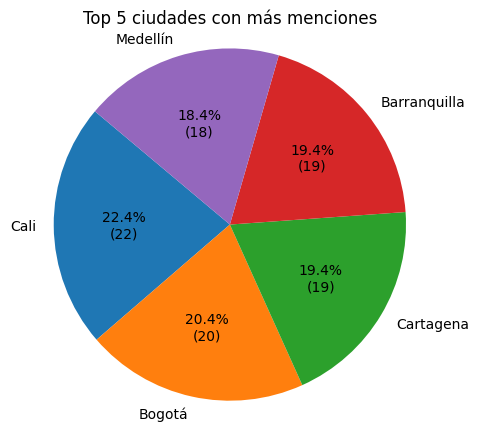

In [101]:
most_common_cities = cities_counter.most_common(5)

labels = [city for city, count in most_common_cities]
sizes = [count for city, count in most_common_cities]

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return my_format

plt.figure(figsize=(5,5))
plt.pie(
    sizes,
    labels=labels,
    autopct=autopct_format(sizes),
    startangle=140
)

plt.title("Top 5 ciudades con más menciones")
plt.axis('equal')
plt.show()

**8. Identificar el producto u objeto con mas comentarios**

In [102]:
noun_counter = Counter()

for comment in comments:
    doc = nlp(comment)
    for token in doc:
        if token.pos_ == "NOUN":
            noun_counter[token.lemma_.lower()] += 1  # usamos lemma para agrupar variantes

# Top 10 productos mencionados
for noun, count in noun_counter.most_common(10):
    print(f"{noun}: {count}")


pedido: 24
servicio: 13
repartidor: 13
comida: 12
experiencia: 12
tiempo: 7
entrega: 6
hamburguesa: 5
soporte: 5
inconveniente: 4


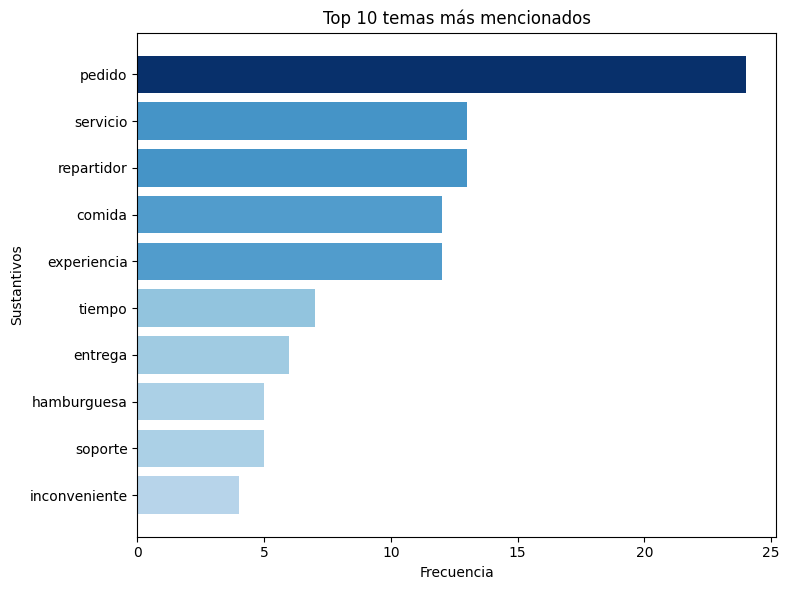

In [113]:
top_nouns = noun_counter.most_common(10)

labels = [noun for noun, count in top_nouns]
values = [count for noun, count in top_nouns]

plt.figure(figsize=(8,6))


norm = plt.Normalize(min(values), max(values))
colors = plt.cm.Blues(0.3 + 0.7 * norm(values))

plt.barh(labels, values, color=colors)

plt.xlabel("Frecuencia")
plt.ylabel("Sustantivos")
plt.title("Top 10 temas más mencionados")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**9. Cual es el porecentaje de comentarios negativos?**

In [83]:
neg_lemmas = [
    "tarde", "retraso", "demorar",
    "frío", "quemar", "aplastar", "derramar",
    "cancelar", "fallar", "error",
    "grosero", "malo", "pésimo",
    "incorrecto", "equivocar",
    "incompleto", "faltar",
    "perder", "lento",
    "esperar"
]

neg_count = 0

for comment in comments:
    doc = nlp(comment.lower())
    lemmas = [token.lemma_ for token in doc]

    if any(neg in lemmas for neg in neg_lemmas):
        neg_count += 1

total_comments = len(comments)
percent_negative = (neg_count / total_comments) * 100

print(f"Comentarios negativos: {percent_negative:.2f}%")

Comentarios negativos: 28.36%


**10. Cuales son las palabras mas frecuentes en los comentarios?**

In [85]:
word_counter = Counter()

for comment in comments:
    doc = nlp(comment)
    for token in doc:
        # Solo palabras reales, sin puntuación ni espacios
        if token.is_alpha and not token.is_stop:
            word_counter[token.lemma_.lower()] += 1


In [86]:
top_n = 20
most_common_words = word_counter.most_common(top_n)
words, counts = zip(*most_common_words)

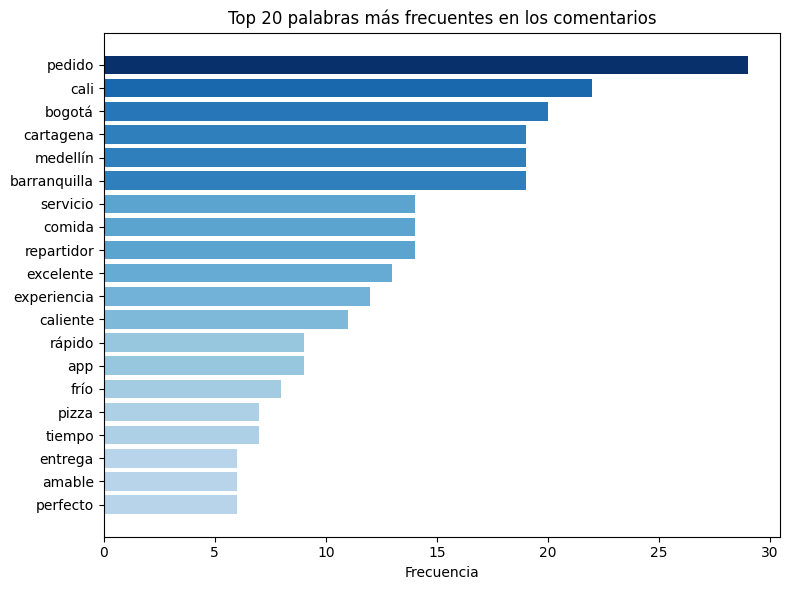

In [110]:
plt.figure(figsize=(8,6))

norm = plt.Normalize(min(counts), max(counts))
colors = plt.cm.Blues(0.3 + 0.7 * norm(counts))

plt.barh(words, counts, color=colors)

plt.xlabel("Frecuencia")
plt.title("Top 20 palabras más frecuentes en los comentarios")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**11. Identifique y grafique de forma agrupada, los tipos de comentarios**

In [88]:
categories_positive = {
    "Entrega rápida": ["rápido", "puntual"],
    "Comida deliciosa": ["delicioso", "rico", "sabroso", "excelente", "perfecto"],
    "Buen precio / Promos": ["barato", "económico", "promo", "descuento", "oferta"],
    "Repartidor amable": ["amable", "respetuoso", "cordial", "educado", "atento"],
    "App fácil / buena": ["fácil", "intuitivo", "práctico"],
    "Buen servicio": ["recomendado", "encantar"]
}

category_counter_pos = Counter()

for comment in comments:
    doc = nlp(comment.lower())
    lemmas = [token.lemma_ for token in doc]

    for cat, keywords in categories_positive.items():
        if any(kw in lemmas for kw in keywords):
            category_counter_pos[cat] += 1
            break

print(category_counter_pos)

Counter({'Comida deliciosa': 16, 'Entrega rápida': 15, 'Repartidor amable': 4, 'Buen precio / Promos': 1, 'App fácil / buena': 1})


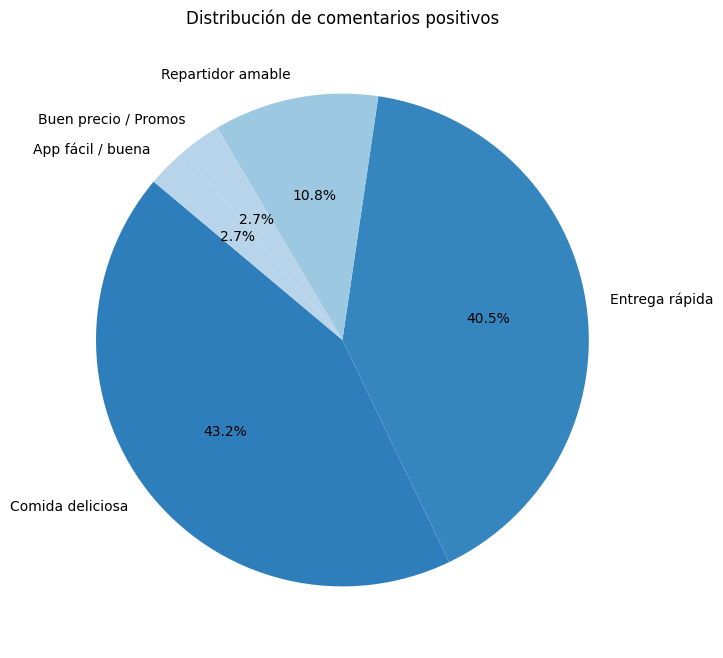

In [118]:
labels = list(category_counter_pos.keys())
sizes = list(category_counter_pos.values())

norm = plt.Normalize(min(sizes), max(sizes))

colors = plt.cm.Blues(0.3 + 0.4 * norm(sizes))

plt.figure(figsize=(8,8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'color': 'black'}
)

plt.title("Distribución de comentarios positivos")
plt.show()

In [91]:
categories_neg = {
    "Retrasos": ["tarde", "demorar", "esperar", "retraso", "lento"],
    "Problema con comida": ["frío", "quemar", "aplastar", "derramar", "crudo"],
    "Pago / Cobro": ["cobrar", "error", "tarjeta"],
    "Entrega incompleta": ["faltar", "incompleto", "cancelar"],
    "Repartidor / Atención": ["grosero", "mal", "responder"]
}

category_counter_neg = Counter()

for comment in comments:
    doc = nlp(comment.lower())
    lemmas = [token.lemma_ for token in doc]

    for cat, keywords in categories_neg.items():
        if any(kw in lemmas for kw in keywords):
            category_counter_neg[cat] += 1
            break

print(category_counter_neg)

Counter({'Retrasos': 16, 'Repartidor / Atención': 9, 'Entrega incompleta': 8, 'Problema con comida': 8, 'Pago / Cobro': 3})


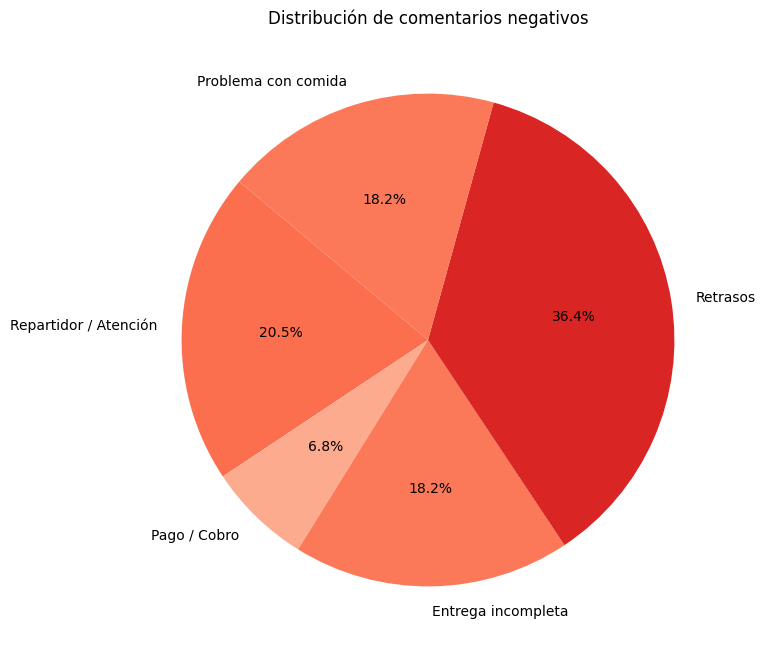

In [119]:
labels = list(category_counter_neg.keys())
sizes = list(category_counter_neg.values())

norm = plt.Normalize(min(sizes), max(sizes))

colors = plt.cm.Reds(0.3 + 0.4 * norm(sizes))

plt.figure(figsize=(8,8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'color': 'black'}
)

plt.title("Distribución de comentarios negativos")
plt.show()

**Conclusión:**

El uso de spaCy permitió mejorar significativamente la calidad del análisis de comentarios, ofreciendo un procesamiento más inteligente que la simple búsqueda de palabras exactas.

Gracias a la **lematización**, se pudieron agrupar distintas variaciones bajo una misma raíz, aumentando la precisión en la detección de patrones. El manejo automático de **stopwords** ayudó a limpiar el texto eliminando palabras irrelevantes, mientras que el reconocimiento de **entidades (NER)** permitió filtrar información como ciudades cuando no era necesaria para el análisis.

Adicionalmente, el uso del **Matcher** permitió definir patrones más avanzados (por lema, categoría gramatical o estructuras específicas), superando las limitaciones de la coincidencia literal de palabras.

En conjunto, spaCy facilitó un análisis más robusto, flexible y profesional, optimizando la clasificación y la interpretación de los comentarios.